# NMR test using NMRglue (Yelle)

## Overview

**Goal:**  Work out the steps for reading 2D NMR data, generating contour plots, generating matrices (meshgrid) for labeling the contour plot axes with correct units, selecting regions of interest (ROIs) and plotting them, and normalizing the NMR data to the methoxy peak

In [1]:
# import supporting libraries
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import nmrglue as ng
import matplotlib.cm as cm
import math

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

#document the versions used
print("numpy version ",np.__version__)
print("matplotlib version ",mp.__version__)
print("nmrglue version ",ng.__version__)

numpy version  1.20.0
matplotlib version  3.3.4
nmrglue version  0.8


In [2]:
# read the data from the first sample processed data 
# guess some universal values (udic) from the Bruker specific dictionary (dic)
dic,data = ng.bruker.read_pdata("data/1/pdata/1")
udic = ng.bruker.guess_udic(dic,data)
print("data type in data array: ",type(data[0,0]))
print("smallest and largest values in the array: ",np.amin(data), np.amax(data))
print("indices of the largest array value: ",np.unravel_index(np.argmax(data, axis=None), data.shape))
print("contents of the universal dictionary: ",udic)

data type in data array:  <class 'numpy.float64'>
smallest and largest values in the array:  -1714954.09375 4864011.828125
indices of the largest array value:  (918, 816)
contents of the universal dictionary:  {'ndim': 2, 0: {'sw': 35213.08675658, 'complex': True, 'obs': 176.047882532221, 'car': 17551.250678991437, 'size': 1024, 'label': '13C', 'encoding': 'echo-antiecho', 'time': True, 'freq': False}, 1: {'sw': 7002.80112044818, 'complex': True, 'obs': 700.130032216749, 'car': 3468.433250986891, 'size': 1024, 'label': '1H', 'encoding': 'direct', 'time': True, 'freq': False}}


In [3]:
# test getting the index of the max value, then getting the value using the index
ind = np.unravel_index(np.argmax(data, axis=None), data.shape)
data[ind]

4864011.828125

In [4]:
# test conversion from Bruker dictionary to the NMRpipe format, and export as an NMRpipe file
# some of the conversion functions process the Bruker specific format poorly, or not at all
# The NMRpipe format is better recognized by conversion functions
C = ng.convert.converter()
C.from_bruker(dic, data)
pdic, pdata = C.to_pipe()
ng.pipe.write("test.fid", pdic, pdata,overwrite=True)

/opt/conda/lib/python3.8/site-packages/nmrglue/fileio/convert.py:68: UserWarning: Incompatible dtypes, conversion not recommended
  warn("Incompatible dtypes, conversion not recommended")


In [5]:
# compare Bruker and NMRpipe array data types
type(data[0,0]), type(pdata[0,0])

(numpy.float64, numpy.complex64)

In [6]:
# try to massage the dictionary into a more readable form
pudic = ng.pipe.guess_udic(pdic,pdata)
pudic

{'ndim': 2,
 0: {'sw': 35213.08675658,
  'complex': True,
  'obs': 176.047882532221,
  'car': 17551.250678991437,
  'size': 1024,
  'label': '13C',
  'encoding': 'states',
  'time': True,
  'freq': False},
 1: {'sw': 7002.80112044818,
  'complex': True,
  'obs': 700.130032216749,
  'car': 3468.4332509868914,
  'size': 1024,
  'label': '1H',
  'encoding': 'magnitude',
  'time': True,
  'freq': False}}

In [7]:
# create unit conversion objects
ucC = ng.pipe.make_uc(pdic,pdata,dim=0)
ucH = ng.pipe.make_uc(pdic,pdata,dim=1)

In [8]:
# locate indices of methoxy peak close to 13C 56ppm, 1H 3.7ppm
# find 
meC = ucC("56 ppm")
meH = ucH("3.7 ppm")

meC, round(ucC.ppm(meC-10),1),round(ucC.ppm(meC+11),1), meH, round(ucH.ppm(meH),1), pdata.real[meC,meH]

(368, 59.8, 51.6, 640, 3.7, 532.1094)

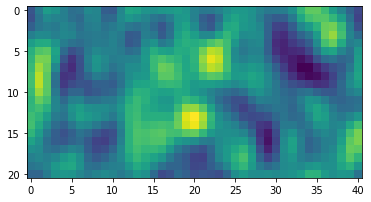

In [9]:
meROI = pdata.real[meC-10:meC+11,meH-20:meH+21]
plt.imshow(meROI)

In [10]:
yMe = meROI[0:len(meROI[0]),20]
zMe = meROI[0:len(meROI[0]),21]
aaMe = meROI[0:len(meROI[0]),22]
abMe = meROI[0:len(meROI[0]),23]
xMe = np.arange(len(yMe))
max(yMe), max(zMe), np.max(meROI), np.argmax(meROI)

(4481.6094, 3433.9844, 4481.6094, 553)

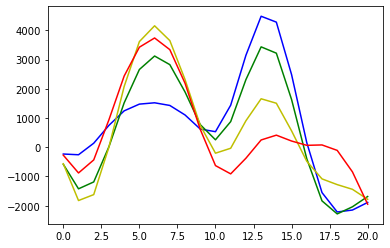

In [11]:
#y=pdata[150,:].real
#z=pdata[250,:].real
#x=np.arange(len(y))
plt.plot(xMe,yMe,'b')
plt.plot(xMe,zMe,'g')
plt.plot(xMe,aaMe,'y')
plt.plot(xMe,abMe,'r')

# Swap the m and n refs to get the shape right? No, use pcolor

In [12]:
n = np.arange(ucC.ppm(meC-10),ucC.ppm(meC+11),(ucC.ppm(meC+11)-ucC.ppm(meC-10))/21)
m = np.arange(ucH.ppm(meH-20),ucH.ppm(meH+21),(ucH.ppm(meH+21)-ucH.ppm(meH-20))/41)
X, Y = np.meshgrid(m,n)
meC, m, n


(368,
 array([3.89907081, 3.88930309, 3.87953537, 3.86976765, 3.85999993,
        3.85023222, 3.8404645 , 3.83069678, 3.82092906, 3.81116134,
        3.80139362, 3.79162591, 3.78185819, 3.77209047, 3.76232275,
        3.75255503, 3.74278731, 3.7330196 , 3.72325188, 3.71348416,
        3.70371644, 3.69394872, 3.684181  , 3.67441329, 3.66464557,
        3.65487785, 3.64511013, 3.63534241, 3.62557469, 3.61580698,
        3.60603926, 3.59627154, 3.58650382, 3.5767361 , 3.56696838,
        3.55720067, 3.54743295, 3.53766523, 3.52789751, 3.51812979,
        3.50836207]),
 array([59.84816971, 59.45750577, 59.06684183, 58.67617788, 58.28551394,
        57.89485   , 57.50418605, 57.11352211, 56.72285817, 56.33219422,
        55.94153028, 55.55086633, 55.16020239, 54.76953845, 54.3788745 ,
        53.98821056, 53.59754662, 53.20688267, 52.81621873, 52.42555478,
        52.03489084]))

In [13]:
np.shape(X), np.shape(Y), np.shape(meROI), X[0], Y[:,0], meROI[0]

((21, 41),
 (21, 41),
 (21, 41),
 array([3.89907081, 3.88930309, 3.87953537, 3.86976765, 3.85999993,
        3.85023222, 3.8404645 , 3.83069678, 3.82092906, 3.81116134,
        3.80139362, 3.79162591, 3.78185819, 3.77209047, 3.76232275,
        3.75255503, 3.74278731, 3.7330196 , 3.72325188, 3.71348416,
        3.70371644, 3.69394872, 3.684181  , 3.67441329, 3.66464557,
        3.65487785, 3.64511013, 3.63534241, 3.62557469, 3.61580698,
        3.60603926, 3.59627154, 3.58650382, 3.5767361 , 3.56696838,
        3.55720067, 3.54743295, 3.53766523, 3.52789751, 3.51812979,
        3.50836207]),
 array([59.84816971, 59.45750577, 59.06684183, 58.67617788, 58.28551394,
        57.89485   , 57.50418605, 57.11352211, 56.72285817, 56.33219422,
        55.94153028, 55.55086633, 55.16020239, 54.76953845, 54.3788745 ,
        53.98821056, 53.59754662, 53.20688267, 52.81621873, 52.42555478,
        52.03489084]),
 array([-1707.3281  ,  -465.78125 ,   684.25    ,   366.01562 ,
         -330.82812 , 

In [14]:
contour_start   = 1     # contour level start value
contour_num     = 5        # number of contour levels
contour_factor  = 1000.0      # scaling factor between contour levels

# calculate contour levels
cl = contour_start * contour_factor * np.arange(contour_num) 
cl

array([   0., 1000., 2000., 3000., 4000.])

Text(0.5, 1.0, 'Methyl Peak 2D Spectrum')

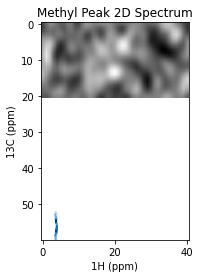

In [15]:
fig, ax = plt.subplots()
plt.imshow(meROI,interpolation='bilinear',cmap=cm.gray)

CS = ax.contour(X,Y,meROI,levels=cl,cmap='Blues')
ax.clabel(CS, inline=True, fontsize=10)
ax.set_xlabel("1H (ppm)")
ax.set_ylabel("13C (ppm)")
ax.set_title("Methyl Peak 2D Spectrum")
#ax.set_ylim(ucC.ppm(meC-10),ucC.ppm(meC+11))
#ax.set_xlim(ucH.ppm(meH-10),ucH.ppm(meH+11))


In [16]:
contour_start   = 1     # contour level start value
contour_num     = 5        # number of contour levels
contour_factor  = 1000.0      # scaling factor between contour levels

# calculate contour levels
cl = contour_start * contour_factor * np.arange(contour_num) 
cl

array([   0., 1000., 2000., 3000., 4000.])

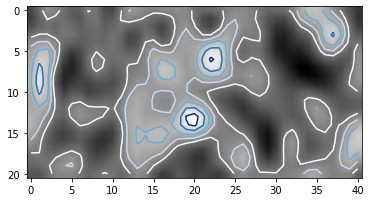

In [17]:
fig2, ax2 = plt.subplots()

im = ax2.imshow(meROI, interpolation='bilinear',cmap=cm.gray)
CS2 = ax2.contour(meROI,cl,cmap='Blues')

In [18]:
n = np.arange(ucC.ppm(meC-10),ucC.ppm(meC+11),(ucC.ppm(meC+11)-ucC.ppm(meC-10))/21)
m = np.arange(ucH.ppm(meH-20),ucH.ppm(meH+21),(ucH.ppm(meH+21)-ucH.ppm(meH-20))/41)
X, Y = np.meshgrid(m,n)
meC, m, n

(368,
 array([3.89907081, 3.88930309, 3.87953537, 3.86976765, 3.85999993,
        3.85023222, 3.8404645 , 3.83069678, 3.82092906, 3.81116134,
        3.80139362, 3.79162591, 3.78185819, 3.77209047, 3.76232275,
        3.75255503, 3.74278731, 3.7330196 , 3.72325188, 3.71348416,
        3.70371644, 3.69394872, 3.684181  , 3.67441329, 3.66464557,
        3.65487785, 3.64511013, 3.63534241, 3.62557469, 3.61580698,
        3.60603926, 3.59627154, 3.58650382, 3.5767361 , 3.56696838,
        3.55720067, 3.54743295, 3.53766523, 3.52789751, 3.51812979,
        3.50836207]),
 array([59.84816971, 59.45750577, 59.06684183, 58.67617788, 58.28551394,
        57.89485   , 57.50418605, 57.11352211, 56.72285817, 56.33219422,
        55.94153028, 55.55086633, 55.16020239, 54.76953845, 54.3788745 ,
        53.98821056, 53.59754662, 53.20688267, 52.81621873, 52.42555478,
        52.03489084]))

In [19]:
contour_start   = 1     # contour level start value
contour_num     = 5        # number of contour levels
contour_factor  = np.max(meROI)//1000
(contour_factor+1)*1000

5000.0

((21, 41), (21, 41), (21, 41))

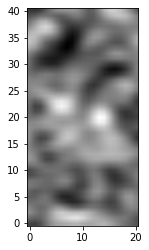

In [20]:
fig2, ax2 = plt.subplots()
#code to set the axis display ranges
#, extent=(-3, 3, -2, 2)
im = ax2.imshow(ng.process.proc_base.xy2yx(meROI), interpolation='bilinear', origin='lower',
               cmap=cm.gray)

#code to set contour levels
levels = np.arange(0, round(np.amax(meROI)), 500)
#CS2 = ax2.contour(X,Y,meROI, cl, origin='lower', cmap='flag', extend='both',
#                linewidths=2)
# extent=(-3, 3, -2, 2)
#CBI = fig.colorbar(im, orientation='horizontal', shrink=0.8)
np.shape(X), np.shape(Y), np.shape(meROI)

In [21]:
round(np.amax(meROI)),round(np.amax(meROI)*0.1)

(4482, 448)

In [22]:
np.arange(0, round(np.amax(meROI)), 500)

array([   0,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])

In [23]:
logMaxROI = math.log10(np.amax(meROI))
logMaxROI,round(logMaxROI), math.floor(logMaxROI),4/3

(3.651433999973448, 4, 3, 1.3333333333333333)

In [24]:
contour_start   = 10000     # contour level start value
contour_num     = 14        # number of contour levels
contour_factor  = 10
#round(math.log(np.amax(meROI)))/math.floor(np.amax(meROI))
#1000.0      # scaling factor between contour levels

# calculate contour levels
cl = contour_start * contour_factor * np.arange(contour_num) 
cl

array([      0,  100000,  200000,  300000,  400000,  500000,  600000,
        700000,  800000,  900000, 1000000, 1100000, 1200000, 1300000])

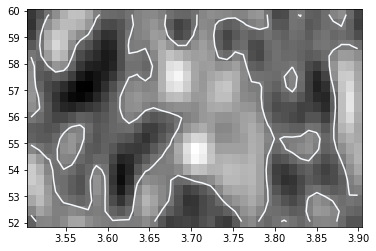

In [25]:
plt.pcolormesh(X,Y,meROI,shading='auto',cmap=cm.gray)
plt.contour(X,Y,meROI,levels=cl,cmap='Blues')

In [26]:
ucC.ppm(1)

199.31519761839712

In [27]:
ucC.ppm(0),ucC.ppm(1023),ucH.ppm(0),ucH.ppm(1023)

(199.70586156210493,
 -199.94335285097645,
 9.955056190266713,
 -0.037319690722712906)

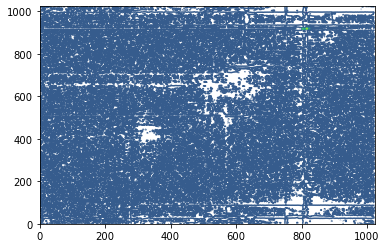

In [28]:
plt.contour(data)

In [29]:
xmax,ymax = np.unravel_index(np.argmax(data, axis=None),data.shape)
xippy = ucH.ppm(xmax)
yippy = ucC.ppm(ymax)
xmax,ymax, xippy,yippy, ucH.ppm(0),ucH.ppm(1023), ucC.ppm(0),ucC.ppm(1023)

                             

(918,
 816,
 0.9882907369448244,
 -119.07591650346143,
 9.955056190266713,
 -0.037319690722712906,
 199.70586156210493,
 -199.94335285097645)

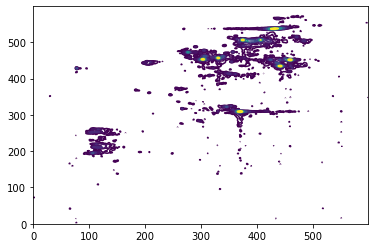

In [30]:
plt.contour(pdata.real[200:800,200:800], levels=[4000, 8000,16000,32000,64000, 128000,256000])

In [31]:
ngridx = 10
tmin = -2.1
tmax = 2.1
tseg = (tmax-tmin)/(ngridx-1)
m = np.linspace(-2.1, 2.1, ngridx)
n = np.linspace(-2.1, ngridx)
o = np.arange(-2.1, 2.1, ngridx)
p = (np.arange(ngridx))
q = -2.1 + tseg*(np.arange(ngridx))
m, n, o, p, q

(array([-2.1       , -1.63333333, -1.16666667, -0.7       , -0.23333333,
         0.23333333,  0.7       ,  1.16666667,  1.63333333,  2.1       ]),
 array([-2.1       , -1.85306122, -1.60612245, -1.35918367, -1.1122449 ,
        -0.86530612, -0.61836735, -0.37142857, -0.1244898 ,  0.12244898,
         0.36938776,  0.61632653,  0.86326531,  1.11020408,  1.35714286,
         1.60408163,  1.85102041,  2.09795918,  2.34489796,  2.59183673,
         2.83877551,  3.08571429,  3.33265306,  3.57959184,  3.82653061,
         4.07346939,  4.32040816,  4.56734694,  4.81428571,  5.06122449,
         5.30816327,  5.55510204,  5.80204082,  6.04897959,  6.29591837,
         6.54285714,  6.78979592,  7.03673469,  7.28367347,  7.53061224,
         7.77755102,  8.0244898 ,  8.27142857,  8.51836735,  8.76530612,
         9.0122449 ,  9.25918367,  9.50612245,  9.75306122, 10.        ]),
 array([-2.1]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([-2.1       , -1.63333333, -1.16666667, -0.7       , -0.2

In [32]:
list(dic)

['procs', 'proc2s', 'acqus', 'acqu2s']

In [33]:
procs = dic['procs']
sf2 = procs['SF']  # scaling factor x axis
si2 = procs['SI']  # number of points x axis
sw2 = procs['SW_p']  # length of x-axis
os2 = procs['OFFSET']  # value of first point on x (ppm)
ncprocs = procs['NC_proc']  # scaling of intensity

sf2, si2, sw2, os2, ncprocs

(700.130032216749, 1024, 7002.8011204482, 9.955056, -6)

In [34]:
proc2s = dic['proc2s']  
sf1 = proc2s['SF']   # scaling factor y-axis (Hz)
si1 = proc2s['SI']  # nr of points y-axis (Hz)
sw1 = proc2s['SW_p']  # length of y-axis 
os1 = proc2s['OFFSET']  # value of first point on y (ppm)

sf1, si1, sw1, os1

(176.047882532221, 1024, 35213.08675658, 199.7059)

In [35]:
f2_ppm=os2-np.arange(si2)/si2/sf2*sw2 #x-axis   ;
f2_ppm[0:5], f2_ppm[-5:-1]

(array([9.955056  , 9.94528828, 9.93552056, 9.92575284, 9.91598513]),
 array([ 0.00175099, -0.00801673, -0.01778444, -0.02755216]))

In [36]:
f1_ppm=os1-np.arange(si1)/si1/sf1*sw1    #y-axis
f1_ppm = np.flip(f1_ppm)
f1_ppm[0:5], f1_ppm[-5:-1]

(array([-0.11870721,  0.07662477,  0.27195674,  0.46728871,  0.66262068]),
 array([198.92457211, 199.11990408, 199.31523606, 199.51056803]))

In [37]:
B = np.array([[0, 1], [1, 0]])
2**-6, B*(2**-6)

(0.015625,
 array([[0.      , 0.015625],
        [0.015625, 0.      ]]))

In [38]:
A = np.array([[0, 1], [2, 3]])
type(A[0,0])

numpy.int64

In [39]:
A1 = A.conj().T
A, A1

(array([[0, 1],
        [2, 3]]),
 array([[0, 2],
        [1, 3]]))

In [40]:
B=A.reshape(1,A.size) 
B1=A1.reshape(1,A1.size)
C=np.concatenate((B,B1))
B,B1,C

(array([[0, 1, 2, 3]]),
 array([[0, 2, 1, 3]]),
 array([[0, 1, 2, 3],
        [0, 2, 1, 3]]))

In [41]:
r= 2**ncprocs
s= B*(2**ncprocs)
t= C*(2**ncprocs)
r,s,t

(0.015625,
 array([[0.      , 0.015625, 0.03125 , 0.046875]]),
 array([[0.      , 0.015625, 0.03125 , 0.046875],
        [0.      , 0.03125 , 0.015625, 0.046875]]))

In [ ]:

plt.pcolormesh(xx,yy,pdata.real,shading='auto',cmap=cm.gray)
plt.contour(xx,yy,meROI,levels=cl,cmap='Blues')